## Actual Code starts here

In [1]:
import pandas as pd
import string
import re

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.getcwd()

'/content'

In [0]:
#SECTION 1
def sentSeg(s):
	#assumes input as raw hindi sentence, with noise 
	#output is a string containing sentences, which are segmented by a new line '\n'
	sindex = []
	chl = []
	bracket = False
	i = 0
	while i<len(s):
		if bracket == False:
			if (s[i]=='।') or (s[i]=='?'):
				sindex.append(i)
			elif (s[i]=='.'):
				if not(i>0 and i<len(s)-1 and s[i-1].isdigit() and s[i+1].isdigit()):
					sindex.append(i)

		if (s[i]=='('):
			bracket = True
		elif (s[i]==')' or s[i]=='\n'):
			bracket = False
		chl.append(s[i])
		i+=1

	for i in range(len(sindex)):
		chl[sindex[i]] = '\n'

	s = ''.join(chl)
	s = re.sub("(\n)+","\n",s)
	s = re.sub("\n$","",s)
	s = re.sub("( )+"," ",s)

	ml = s.split('\n')
	i = 0
	while i < len(ml):
		if len(ml[i].strip('\n')) < 3:
			ml[i] = ""
		else:
			ml[i] = ml[i].strip()
		i+=1
	s = '\n'.join(ml)
	s = re.sub("(\n)+","\n",s)
	return s

#SECTION 1.01 : Remove Rows with no summary
def removeNan(df):
	df = df.dropna()
	return df

#SECTION 1.1
def removeEnglishLines(s, maxPercentage=0.5):
	# assumes input as hindi sentences, segmented by new line '\n'
	ml = s.split('\n')
	i = 0
	while i < len(ml):
		j = 0
		for x in ml[i]:
			# print(x,end=' ')
			if (x>='a' and x<='z') or (x>='A' and x<='Z'):
				j+=1
		if j > int(len(ml[i])*maxPercentage):
			ml[i] = ""
		i+=1
	s = "\n".join(ml)
	s = re.sub("(\n)+","\n",s)
	s = re.sub("\n$","",s)
	return s

# SECTION 1.1
def englishPhrases(s):
	# assumes input as hindi sentences, segmented by new line '\n'
	ml = s.split('\n')
	i = 0
	while i < len(ml): #iterate over each sent
		msl = ml[i].split(' ') 
		hichar = False
		bracket = False
		j = 0
		while j <len(msl)-1: #iterate over each word, skip last because it is '\n'
			if ('(' in msl[j]):
				bracket=True
			if bool(re.search(r"[\u0900-\u097F]",msl[j])) == False and bool(re.search(r"\d",msl[j])) == False and (bracket==False) and (bool(re.search(r"[a-z]",msl[j]))): #has no Hindi alphabets and no numbers and bracket is not open and it contains atleast one english alphabet (bcoz it messes up in punctuations)
				msl[j] = "<ENG>"
			# else:
			# 	print(msl[j])
			if(')' in msl[j]):
				bracket=False
			j+=1
		ml[i] = ' '.join(msl)
		i+=1
	s = "\n".join(ml)
	# s = re.sub("(<ENG> ?)+","<ENG> " ,s)
	return s


#SECTION 2
def removeRepeatingSents(s):
	ml = s.split('\n')
	i = 1
	while i < len(ml):
		if (ml[i] in ml[:i]):
			ml = ml[:i]+(ml[i+1:] if i+1<len(ml) else [])
			i-=1
		i+=1
	i = 0
	while i < len(ml):
		ml[i] = ml[i].replace("टिप्पणियां",'').replace('-',' ')
		i+=1
	s = '\n'.join(ml)
	s = re.sub("(\n)+","\n",s)
	s = s.strip('\n').strip(' ')
	return s

def checkforDigitsinThisWord(w):
	if (any(char.isdigit() for char in w)):
		return "<NUM>"
	else:
		return w

#Section 3 Remove Numbers
#Currently does not merge <NUM>s separated by a dash or ' ' for ranges
def removeNumbers(df):
	#Remove indexing, otherwise causes indexing problems
	df = df.reset_index(drop=True)
	for i in df:
		for j in range(len(df[i])):
			text=df[i][j]
			#Assuming space separated --aamir
			#incorrect assumption, sometimes summaries are multiline i.e. separated by new line --ritwik
			#we can do it by regex BUT the main issue comes when numbers are mixed with alphabets like "R2D2" or "टि20".
			#You will need to handle spaces, new lines, hindi characters, english characters and repeating patterns. It will be a tedious regex to write. --ritwik
			words=text.split(' ')
			bracket=False
			for k in range(len(words)):
				if '(' in words[k]:
					bracket=True
				elif bracket==False:
					if ("\n" in words[k]):
						subwords = words[k].split('\n')
						for m in range(len(subwords)):
							subwords[m] = checkforDigitsinThisWord(subwords[m])
						words[k] = '\n'.join(subwords)
					else:
						words[k] = checkforDigitsinThisWord(words[k])
				if ')' in words[k]:
					bracket=False
			df[i][j]=' '.join(words)
	return df

#SECTION 4
def removeTinyArticles(df,minLength=50):
	df = df.reset_index(drop=True)
	for i in range(len(df['article'])):
		text=df['article'][i]
		words=text.split(' ')
		count=len(words)
		if(count<minLength):
			df['article'][i]=float('NaN')
	df=removeNan(df)
	return df

def removeTinySummaries(df,minLength=10):
	df = df.reset_index(drop=True)
	for i in range(len(df['summary'])):
		text=df['summary'][i]
		words=text.split(' ')
		count=len(words)
		if(count<minLength):
			df['summary'][i]=float('NaN')
	df=removeNan(df)
	return df

#Section 5 Questions remover
#Ensure removeMultipleSpaces has been called, because last character needs to be a space
#Call removeNan to remove these lines
def removeQuestions(df):
	df=df.applymap(lambda x: x if (re.search('\?$',x)==None) else float('NaN'))
	df=removeNan(df)
	return df

#Section 6 Remove Brackets
def removeBrackets(df):
	df = df.reset_index(drop=True)
	for i in range(len(df['article'])):
		words=df['article'][i]
		brackets=0
		replacedSentence=''
		for j in words:
			if(j=='('):
				brackets+=1
			elif(j==')'):
				brackets-=1
				continue
			if(brackets==0):
				replacedSentence+=j
		df['article'][i]=replacedSentence
	return df

#Section 7 Remove Punctuation
def removePunctuation(df):
	df=df.applymap(lambda x: x.replace('|',' '))
	pstr = (string.punctuation+"‘’").replace('<','').replace('>','')
	df=df.applymap(lambda x: x.translate(str.maketrans('', '', pstr)))
	return df

def removeSpaces(s): #sometimes some lines just contain spaces
	ml = s.split('\n')
	i = 0
	while i< len(ml):
		ml[i] = ml[i].strip()
		i+=1
	s = '\n'.join(ml)
	return s

In [0]:
#Step 1 : Load the dataset
# train_df=pd.read_csv('/content/drive/My Drive/_SEM8/DL/Project/train.csv',lineterminator='\n')
train_df=pd.read_csv('./drive/My Drive/DL_final/test.csv',lineterminator='\n')

In [6]:
# train_df=pd.read_csv('train.csv',lineterminator='\n')
print(train_df)
print(train_df.columns)
train_df=removeNan(train_df)
print('Blank entries removed')
train_df['article'] = train_df['article'].apply(sentSeg)
train_df['summary'] = train_df['summary'].apply(sentSeg)
print('Sent Segmentation Done')

train_df['article'] = train_df['article'].apply(removeEnglishLines)
train_df['summary'] = train_df['summary'].apply(removeEnglishLines)
print('English lines Removed')

train_df['article'] = train_df['article'].apply(englishPhrases)
print('English Phrases in article changed to <ENG>')
train_df['summary'] = train_df['summary'].apply(englishPhrases)
print('English Phrases in summary changed to <ENG>')

train_df = removeNumbers(train_df)
print('Numbers changed to <NUM>')
train_df = removeQuestions(train_df)
print('Questions removed')
train_df = removeBrackets(train_df)
print('Bracketted text removed')

train_df['article'] = train_df['article'].apply(removeRepeatingSents)
train_df['summary'] = train_df['summary'].apply(removeRepeatingSents)
print('Repeated sents removed')

train_df=removeTinyArticles(train_df)
print('Tiny articles removed')
train_df=removeTinySummaries(train_df)
print('Tiny summaries removed')
train_df = removePunctuation(train_df)
print('Punctuation removed')

train_df['article'] = train_df['article'].apply(removeSpaces)
print('article spaces-lines removed')
train_df['summary'] = train_df['summary'].apply(removeSpaces)
print('summary spaces-lines removed')
train_df=removeNan(train_df)
print('Blank entries removed just to be sure!')

print(train_df)

                                                headline  ...                                            article
0      पाकिस्तानी जासूस को मिली अहम खुफिया जानकारी, ज...  ...  जम्मू कश्मीर पुलिस के एक अधिकारी ने घाटी में प...
1      अमर को अस्पताल से छुट्टी, बोले, सपा से अब नाम ...  ...  नोट के बदले वोट मामले में आरोपी समाजवादी पार्ट...
2      केजरीवाल ने उप राज्यपाल से सिख विरोधी दंगों की...  ...  आम आदमी पार्टी (आप) और अकाली दल ने बुधवार को द...
3      सैलरी नेगोश‍िएट करते वक्‍त भूलकर भी न कहें ये ...  ...            VIDEO: अब सैलरी होगी कम, सेविंग ज़्यादा!
4            इंटरनेट से पता कीजिए कहां तक पहुंची ट्रेन    ...  रेल नेविगेशन से संबंधित आईआईटी कानपुर की महत्व...
...                                                  ...  ...                                                ...
35963  फ्लैग मीटिंग से पहले पाक ने की नांगरी-टेकरी इल...  ...  नियंत्रण रेखा पर चल रहे तनाव को कम करने के लिए...
35964  कांग्रेस के 50 उम्मीदवारों की सूची, चिदंबरम नह...  ...  कांग्रेस ने गुरुवार को वित्तमंत्र

In [0]:
# SAVING
# train_df.to_csv('/content/drive/My Drive/_SEM8/DL/Project/train_clean.csv',index=None)
train_df.to_csv('./drive/My Drive/DL_final/test_clean.csv',index=None)

In [8]:
len(train_df)

14877

In [0]:
!ls drive/My\ Drive/Colab\ Notebooks/hi_fb/*

'drive/My Drive/Colab Notebooks/hi_fb/cc.hi.300.bin.gz'
'drive/My Drive/Colab Notebooks/hi_fb/test.csv'
'drive/My Drive/Colab Notebooks/hi_fb/train2.csv'
'drive/My Drive/Colab Notebooks/hi_fb/train_clean.csv'
'drive/My Drive/Colab Notebooks/hi_fb/train.csv'
'drive/My Drive/Colab Notebooks/hi_fb/trainWords.set'


## Actual Code Ends here

In [0]:
"""
========
NEW CODE
========
"""

'\n========\nNEW CODE\n========\n'

In [0]:
#Imports

import pandas as pd
import string
import re
import copy

In [0]:
"""
re.split('; |, |\*|\n',a)
"""

"\nre.split('; |, |\\*|\n',a)\n"

In [0]:
#Section 1.02 Remove Escaped Characters

#Commented replace \n because it is required
def removeEscapedCharacter(df):
    #df=df.applymap(lambda x: x.replace('\n',' '))
    df=df.applymap(lambda x: x.replace('\r',' '))
    df=df.applymap(lambda x: x.replace('\t',' '))
    df=df.applymap(lambda x: x.replace('\xa0',' '))
    df=df.applymap(lambda x: x.replace('\u200d',' '))
    df=df.applymap(lambda x: x.replace('‘',' '))
    df=df.applymap(lambda x: x.replace('’',' '))
    df=df.applymap(lambda x: x.replace('\'',' '))
    df=df.applymap(lambda x: x.replace('\"',' '))
    return df

In [0]:
#Section 1.03 Remove Multiple Spaces
def removeMultipleSpaces(df):
    df=df.applymap(lambda x:' '.join(x.split()))
    return df

In [0]:
#Section 1.1 Remove English Characters
#Currently does not merge <ENG>s separated by a dash or ' ' for ranges
def removeEnglish(df,tolerance=0.2):
    #Remove indexing, otherwise causes indexing problems
    df = df.reset_index(drop=True)
    for i in df:
        for j in range(len(df[i])):
            text=df[i][j]
            #Assuming space separated
            words=text.split(' ')
            for k in range(len(words)):
                if(re.search('.*[a-zA-Z].*', words[k])!=None):
                    words[k]='<ENG>'
            eng=words.count('ENG')*1.0            
            total=len(words)*1.0
            ratio=eng/total
            if(ratio>tolerance):
                df[i][j]=float('NaN')
            else:
                df[i][j]=' '.join(words)
    df=removeNan(df)
    return df

In [0]:
#Section 1.2 Remove Noisy Lines
#Should be taken care by removeNan because these lines most probably do not have summaries
def removeNoisyLines(df):
    return df

In [0]:
#Section 2
def removeDuplicates(df):
    df=df.drop_duplicates()
    return df

def removeDuplicateSentences(df):
    for i in df:
      continue


In [0]:
#Section 3 Remove Numbers
#Currently does not merge <NUM>s separated by a dash or ' ' for ranges
def removeNumbers(df):
    #Remove indexing, otherwise causes indexing problems
    df = df.reset_index(drop=True)
    for i in df:
        for j in range(len(df[i])):
            text=df[i][j]
            #Assuming space separated
            words=text.split(' ')
            for k in range(len(words)):
                if(any(char.isdigit() for char in words[k])):
                    words[k]='<NUM>'
            df[i][j]=' '.join(words)
    return df

In [0]:
#Section 4 Remove Tiny Articles
def removeTinyArticles(df,minLength=50):
    df = df.reset_index(drop=True)
    for i in range(len(df['article'])):
        text=df['article'][i]
        words=text.split(' ')
        count=len(words)
        if(count<minLength):
            df['article'][i]=float('NaN')
    df=removeNan(df)
    return df

In [0]:
#Section 5 Questions remover
#Ensure removeMultipleSpaces has been called, because last character needs to be a space
#Call removeNan to remove these lines
def removeQuestions(df):
    df=df.applymap(lambda x: x if (re.search('\?$',x)==None) else float('NaN'))
    df=removeNan(df)
    return df

In [0]:
#Section 6 Remove Brackets
def removeBrackets(df):
    df = df.reset_index(drop=True)
    for i in range(len(df['article'])):
        words=df['article'][i]
        brackets=0
        replacedSentence=''
        for j in words:
            if(j=='('):
                brackets+=1
            elif(j==')'):
                brackets-=1
                continue
            if(brackets==0):
                replacedSentence+=j
        df['article'][i]=replacedSentence
    return df

In [0]:
#Section 7 Remove Punctuation
def removePunctuation(df):
    df=df.applymap(lambda x: x.replace('|',' '))
    df=df.applymap(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return df

In [0]:
#Small Sample dataframe for quick testing of code
df=copy.deepcopy(train_df[:30])
df = df.reset_index(drop=True)
print(len(train_df))
print(len(df))

69033
30


In [0]:
train_df=removeNan(train_df)
print(len(train_df))
df=removeNan(df)
print(len(df))

69033
30


In [0]:
df=removeNan(df)

In [0]:
df=removeEnglish(df)

In [0]:
df=removeNumbers(df)

In [0]:
df=removeMultipleSpaces(df)

In [0]:
df=removeQuestions(df)

In [0]:
df=removeDuplicates(df)

In [0]:
df=removePunctuation(df)

In [0]:
df=removeBrackets(df)

In [0]:
df=removeEscapedCharacter(df)

In [0]:
df=removeTinyArticles(df)

In [0]:
df

,headline,summary,article
0,रिम करेगा दो हजार कर्मचारियों की छंटनी,ब्लैकबेरी हैंडसेट बनाने वाली कनाडा की कंपनी रि...,ब्लैकबेरी हैंडसेट बनाने वाली कनाडा की कंपनी रि...
1,अमेरिका राष्ट्रपति पद की उम्मीदवार हिलेरी क्ल...,श्रद्धांजलि सभा के दौरान अचानक खराब हुई हिलेरी...,अमेरिका में राष्ट्रपति पद के लिए डेमोक्रेटिक प...
2,देश के सर्वश्रेष्ठ स्पिनरों में से एक है हरभजन...,पूर्व भारतीय कप्तान अनिल कुंबले का मानना है कि...,पूर्व भारतीय क्रिकेट कप्तान अनिल कुंबले का मान...
3,इंडिगो के स्टाफ ने दिल्ली एयरपोर्ट पर पैसेंजर ...,इंडिगो के ग्राउंड स्टाफ ने यात्री से की हाथापा...,इंडिगो एयरलाइन के प्रेसीडेंट और डायरेक्टर आदित...
4,नव्या नवेली के साथ दोस्ती पर जावेद जाफरी के बे...,मीजान जाफरी ने किया खुलासा नव्या नंदा को बताया...,संजय लीला भंसाली की फिल्म मलाल से बॉलीवुड में ...
6,इस्लामिक धर्मगुरु ने रियल एस्टेट में किया NUM ...,ज़ाकिर नाइक के NUM बैंक खातों की एनआईए जांच कर...,विवादित इस्लामिक प्रचारक ज़ाकिर नाइक के गैर सर...
7,राष्ट्रपति NUM दिवसीय दौरे पर सेशेल्स व द अफ्र...,राष्ट्रपति प्रतिभा पाटील रविवार सुबह सेशेल्स औ...,राष्ट्रपति प्रतिभा पाटील रविवार सुबह सेशेल्स औ...
8,पीएम मोदी मिले बीजेपी के ओबीसी सांसदों से सरका...,कहा जब संसद नहीं चल रही हो तो अपने क्षेत्र में...,उन्होंने कहा कि अपने क्षेत्रों की समस्याओं को ...
9,ENG ENG ENG सलमान खान दिखे बुजुर्ग के गेटअप मे...,सलमान खान दिखे बुजुर्ग के गेटअप में उनकी तस्वी...,ENG ENG ENG ENG ENG ENG ENG ENG ENG ENG ENG EN...
10,सोमालियाई लुटेरों ने NUM भारतीयों को किया रिहा,फरवरी में इटली के इस जहाज का अपहरण किया गया था...,रोम में सोमालियाई समुद्री लुटेरों ने इटली के ए...


530.8108143703812


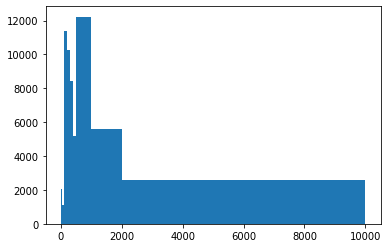

In [0]:
#Function to plot Summary Lenght Distribution
import matplotlib.pyplot as plt
def getSummaryLengthDistribution(df):
    count=[]
    df = df.reset_index(drop=True)
    for i in range(len(df['article'])):
        text=df['article'][i]
        #print(text)
        words=text.split(' ')
        #print(len(words))
        count.append(len(words))
    print(sum(count)/len(df['article']))
    count.sort()
    plt.hist(count,[1,10,20,30,40,50,60,70,80,90,100,200,300,400,500,1000,2000,10000])
    plt.show()
getSummaryLengthDistribution(train_df)